# Setup


In [277]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from numpy.random import dirichlet as diri

dl = DataLib("SignalData")

In [278]:
# Pull all the necessary dataframes to avoid duplicate code. 
BondRetIdx = dl.pull("BondRetIdx/LocalFX")
LongRates = dl.pull("LongRates")
ShortRates = dl.pull("ShortRates")
EquityPrices = dl.pull("EquityPrices")
M1 = dl.pull("M1/inUSD")
M2 = dl.pull("M2/inUSD")
M3 = dl.pull("M3/inUSD")
CurrAcctNom = dl.pull("CurrAcctNom/inUSD")
CurrAcctPctGDP = dl.pull("CurrAcctPctGDP")
nGDP = dl.pull("GDP/Nominal")
rGDP = dl.pull("GDP/Real")
nFxTrdWts = dl.pull("fxTrdWts/Nominal")
rFxTrdWts = dl.pull("fxTrdWts/Real")
fxVsUSD = dl.pull("fxVsUSD")
CoreCPI = dl.pull("CoreCPI/SA")

In [290]:
# Constants. 
WORKDAYS_IN_MONTH=21
WORKDAYS_IN_YEAR=261
QUARTERS_IN_YEAR=4

# Conventions

For the sake of sanity, I'm going to outline a few conventions here. 
- Variables which are directly from the datalib should begin with capital letters (e.g. `ShortRates`). 
    - Others variables should be lowercase with underscore separation. 
    - Derived variables (from datalib) can have capitals, but should be suffixed with underscore notation. 
- datalib variables should never be loaded again. They are loaded above. 
- Returns should always be graphed in red. No other indicator should ever be graphed in red. 

# Intro

What indicators should we choose? Why?
- FX Appreciation
- Monetary Base (captures something orthogonal to movements in FX) 
- GDP (are there any other data that we can supplement this with?)

Which shouldn't we choose? Why? 
- Change in GDP: as the prospectus outlines, changes in GDP are revised regularly. Additionally, GDP statistics are released with a lag, so wouldn't be practical for a real investment system. 
- Relative Stock/Bond Performance: this indicator seems to have an unsatisfying and hand-wavy explanation for how it affects bond returns. 
- Monetary Base: since monetary base in only useful if we assume an increase in monetary base is indicative of expansionary policy. This is not the case right now amidst the COVID-19 pandemic, however. (Is this a good enough reason to discount it?)

How are the indicators we have chosen related? Or are they unrelated? 
- The exchange rate is a function of inflow/outflow of money, which is related to economic growth, interest rates, and monetary base. So yes, all three are related. 

it may be interesting to consider not only each indicator in isolation, but how they may or may not complement one another -- what potential synergies might they have? redundancies?

# GDP
`TODO`: 
1. provide an overview of why we are using this indicator
2. (decide what data could supplement GDP)
3. (decide what data feeds we are going to need)
4. (find these on eikon)
5. (how should we manipulate the data)
6. (get some dataframes from datalib and Eikon)
7. generate an indicator

**1 - overview**

Questions that are relevant here: why do we use GDP for bond price prediction? What even is GDP? How is it measured? Are there any problems with how it is measured? Do we want to look at absolute GDP, or change, and why? 
- GDP: Gross domestic product. The sum of transactions within an economy. A proxy for the busyness of an economy. 
- It is measured in dollars. Some GDP measures take a while to be released, and hence may be somewhat impractical for a real investment system. 
- Absolute GDP is pretty nonsensical when we're trying to predict soveign bonds. The US having 100x more GDP than New Zealand tells us nothing about the price movements of bonds in those respective countries. Change is a more useful measure than magnitude for this reason. 

**2 - what other data could supplement GDP?**
- GDP itself
- unemployment
- HDI

**7 - generating an indicator**

Questions to be addressed:
- What relationship exists between GDP and returns? 
- What conceptual relationship exists between GDP and returns? Does this conflict with what we actually see?
- What relationship exists between GDP & yield?
- How should we apply smoothing? 

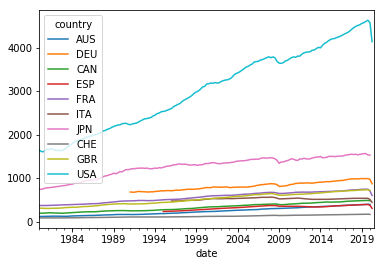

In [215]:
rGDP = dl.pull('GDP/real')
rGDP.plot()

Let's look at the change in GDP - that might be more informative. Plotting the USA GDP change we notice fairly slow growth over the past 40 years, and a major negative dip since COVID-19. 

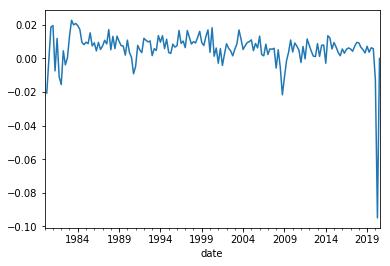

In [49]:
rGDP_change = rGDP.pct_change()
rGDP_change['USA'].plot()

Let's try smoothing that curve a little. We'll start with a yearly rolling average.

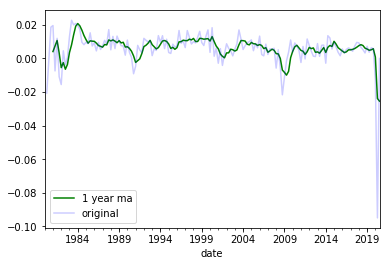

In [283]:
rGDP_1yr_ma = rGDP_change.rolling(QUARTERS_IN_YEAR).mean()
rGDP_1yr_ma['USA'].plot(color='green')
rGDP_change['USA'].plot(color='blue', alpha=0.2)
plt.legend(['1 year ma', 'original'])

Is there a relationship between bond returns and GDP? 

In [240]:
def zscore(df): return (df - df.mean()) / df.std()

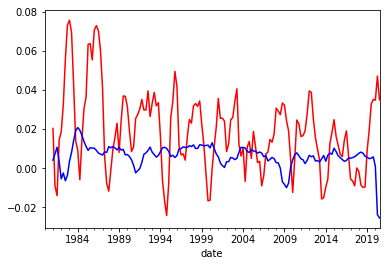

In [284]:
# Resample the return index to be quarterly, to align with rGDP. 
BondRetIdx_change = BondRetIdx.resample('Q').mean().pct_change()
BondRetIdx_1yr_ma = BondRetIdx_change.rolling(QUARTERS_IN_YEAR).mean()
BondRetIdx_1yr_ma['USA'].plot(color='red')
rGDP_1yr_ma['USA'].plot(color='blue')

It would appear that change in GDP and bond returns have a negative correlation (i.e. GDP change goes down, bond returns increase). What are the mechanics behind this? *Increased GDP growth --> central bank tightening economy --> higher interest rates --> lower bond prices (and ergo, returns)*

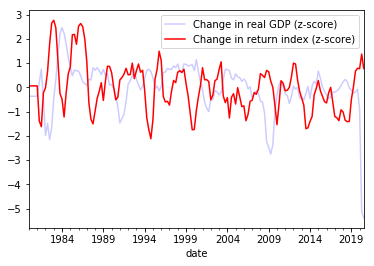

In [288]:
# Convert ma's of GDP change and bond return change to z-scores.
# TODO: should we be backfilling here? What to do in the case of missing data? 
BondRetIdx_z = zscore(BondRetIdx_1yr_ma).fillna(method='bfill')
rGDP_z = zscore(rGDP_1yr_ma).fillna(method='bfill')
rGDP_z['USA'].plot(color='blue', alpha=0.2)
BondRetIdx_z['USA'].plot(color='red')
plt.legend(['Change in real GDP (z-score)', 'Change in return index (z-score)'])


Let's also look at the correlation of the two timeseries. [Here](https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9) is more info about different types of correlation. Below we use Pearson correlation which indicates the linear relationship between two signals, ranging from -1 to 1. Pearson does not provide information about directionality (i.e. which leads which).

In [289]:
rGDP_z['USA'].corr(BondRetIdx_z['USA'], method='pearson')

-0.2211024604676885

# Monetary Base

`TODO`: 
1. provide an overview of why we are using this indicator
2. (decide what data could supplement GDP)
3. (decide what data feeds we are going to need)
4. (find these on eikon)
5. (how should we manipulate the data)
6. (get some dataframes from datalib and Eikon)
7. generate an indicator

**1 - overview of this indicator**
- money supply as a proxy for economic growth does not resonate --> in fact it might indicate the opposite of growth. Because of this, money supply might be a good complement to GDP (we might expect them to have negative correlations). Actually - does this make monetary base redundant? 
- often money supply grows at its fasted when the central bank is trying to stimulate a weak economy. Japan has been pumping money into the system for decades for little to no effect, either in terms of spuring growth or generating their desired level of inflation. Japan's a good case study for how money supply growth spurring inflation may break down. 

**7 - generate an indicator**

This is a little problematic because not all countries have M1/M2/M3. We need a way to have a standardized measure of money supply. We can simply do this by using M3 (although the US doesn't have M3).
- Countries missing M1: none
- Countries missing M2: AUS
- Countries missing M3: USA

Solution: 
- AUS: equal weight M1 & M3
- USA: equal weight M1 & M2
- Everyone else: equal weight M1, M2, M3. 

In [317]:
M1_change = M1.pct_change()
M2_change = M2.pct_change()
M3_change = M3.pct_change()
agg_ms_change = (1/3) * M1_change + (1/3) * M2_change + (1/3) * M3_change

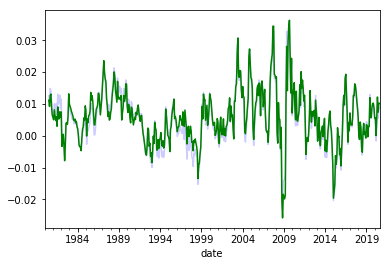

In [324]:
# Let's see how equal weighting money supply changes can approximate
# change in a particular indicator. 
M2_change['CAN'].rolling(6).mean().plot(color='blue', alpha=0.2)
agg_ms_change['CAN'].rolling(6).mean().plot(color='green')

# Sample Returns Stream
To speed up development, here we're going to make a two dummy signals. Our signal will be a time series of data telling us how long and how short to go in each bond market. Our long and short positions must be offsetting. We will use two dummy signals: 
- An equal weighting scheme (all long)
- A randomly weighted scheme using a Dirichlet distribution (equal long/short)

In [216]:
# Get the data (just use the year 2000 for simplicity).
BondRetIdx = dl.pull("BondRetIdx/LocalFX")
index = BondRetIdx.index
mask = (index >= '2000-1-1') & (index < '2001-1-1')
df = BondRetIdx.loc[mask]

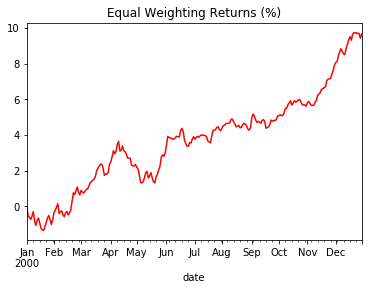

In [287]:
# Calculate our returns using an equal-weighted long-only scheme. 
abbr_return_index = BondRetIdx[mask]
abbr_returns = abbr_return_index.pct_change()
equal_weight_returns = (0.1 * abbr_returns).sum(axis=1)
cumul_returns = ((equal_weight_returns + 1).cumprod() - 1) * 100
cumul_returns.plot(title='Equal Weighting Returns (%)', color='red')

Let's now generate the random signal with equal weight in longs and shorts. 

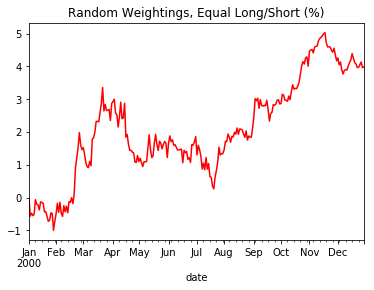

In [286]:
# Create a random signal with longs and shorts. 
signal = pd.DataFrame(df)
for ind in df.index: 
    signal.at[ind] = np.append(diri(np.ones(5),size=1), -1*diri(np.ones(5),size=1))

# Calculate the returns. 
custom_weight_returns = (signal * abbr_returns).sum(axis=1)
cumul_returns = ((custom_weight_returns + 1).cumprod() - 1) * 100
cumul_returns.plot(title="Random Weightings, Equal Long/Short (%)", color='red')